In [1]:
!pip install keras-tuner -q

In [8]:
# import system libs

import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers


from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from kerastuner import HyperParameters, Hyperband, GridSearch
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from tensorflow.keras.models import load_model


import kagglehub
import glob

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
is_colab_env = True


if is_colab_env:
    from google.colab import drive
    drive.mount('/content/drive')
    save_path = '/content/drive/MyDrive/brain_tumor_models'
    os.makedirs(save_path, exist_ok=True)

    # download dataset from kaggle
    path = kagglehub.dataset_download("denizkavi1/brain-tumor")
    print("Path to dataset files:", path)
else:
    path = "/kaggle/input/brain-tumor"

## Load dataset

In [3]:
print("\nfile list:")
for file in glob.glob(f"{path}/*"):
    print(file)


file list:
/kaggle/input/brain-tumor/2
/kaggle/input/brain-tumor/3
/kaggle/input/brain-tumor/1


In [4]:
# load the whole dataset


data_dir = path
batch_size = 32
img_height = 224
img_width = 224


def augment(image, label):
    image = tf.image.random_flip_left_right(image) # random horizontal flip
    image = tf.image.random_flip_up_down(image) # random vertical flip
    image = tf.image.random_brightness(image, max_delta=0.1) # random brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2) # random contrast
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2) # random saturation

    return image, label


# generate the whole dataset, without validation_split
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,  # shuffle
    seed=123
)


# calculate the size of train and test dataset
dataset_size = full_dataset.cardinality().numpy()
train_size = int(0.8 * dataset_size)  # 80% train
test_size = dataset_size - train_size  # 20% test


# split
train_ds = full_dataset.take(train_size)
test_ds = full_dataset.skip(train_size)


# apply data augmentation on train_ds
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)



# check the size of each dataset
print(f"Total dataset size: {dataset_size}")
print(f"Train dataset size: {train_ds.cardinality().numpy()}")
print(f"Test dataset size: {test_ds.cardinality().numpy()}")

Found 3064 files belonging to 3 classes.
Total dataset size: 96
Train dataset size: 76
Test dataset size: 20


Show images

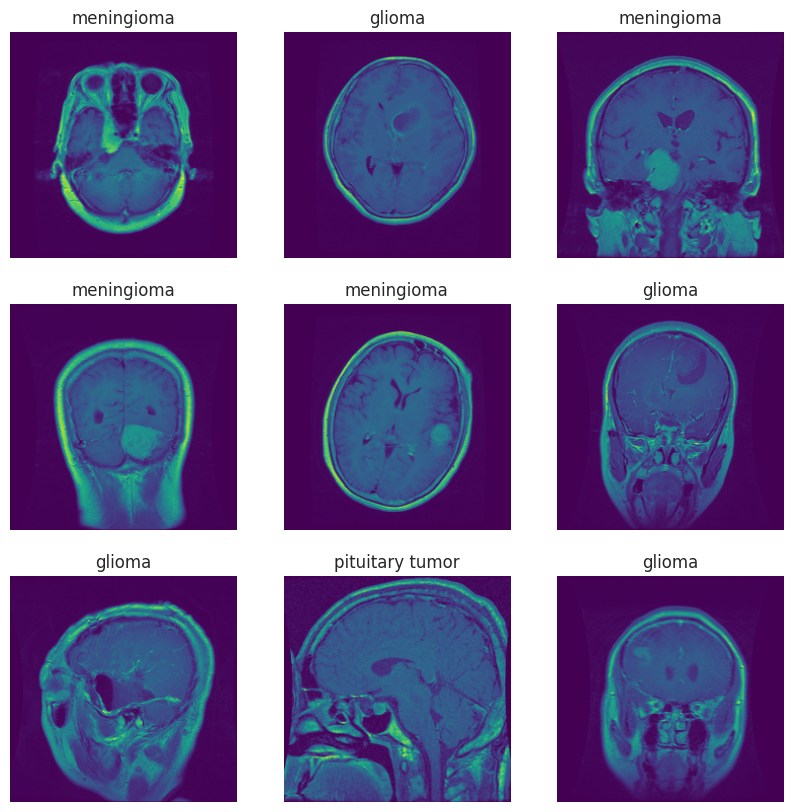

In [24]:
label_map = {
    0: "meningioma",
    1: "glioma",
    2: "pituitary tumor"
}

test_images, test_labels = next(iter(test_ds))

num_images = 9
plt.figure(figsize=(10, 10))

for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].numpy().astype("uint8"))
    plt.title(label_map[test_labels[i].numpy()])
    plt.axis("off")

plt.show()

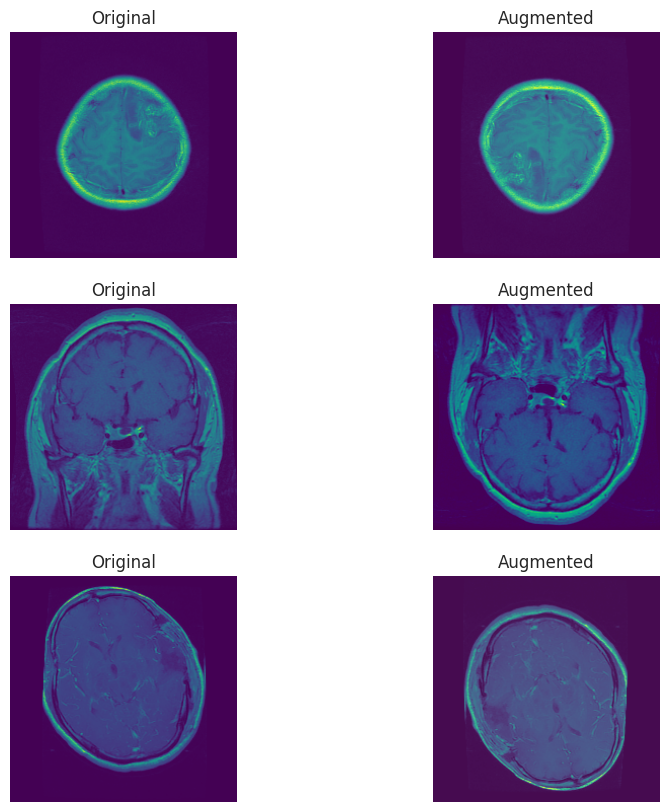

In [27]:
test_images, test_labels = next(iter(test_ds))

num_images = 3
plt.figure(figsize=(10, 10))

for i in range(num_images):
    original_image = test_images[i]
    augmented_image, _ = augment(original_image, test_labels[i])
    
    ax = plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(original_image.numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")
    
    ax = plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.show()

In [5]:
# we have 3 classes

classes_count = 3
img_height = 224
img_width = 224

In [7]:
# firstly, we use the default VGG16 model, not tuning


def build_model_vgg16_basic():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = False  # freeze the convolutional layers

    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = base_model(inputs)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes_count, activation='softmax')(x)

    model = keras.Model(inputs, outputs)


    model.compile(optimizer=Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [8]:
# secondly, we use the VGG16 model with tuning

# we want to tune, 1. the number of neurons in the dense layer, 2. the learning rate

def build_model_vgg16(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = False 

    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = base_model(inputs)
    x = layers.Flatten()(x)

    # units and learning_rate
    units = hp.Choice('units', values=[128, 256, 512])
    lr = hp.Choice('learning_rate', values=[1e-4, 1e-3])
    
    x = layers.Dense(units=units, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes_count, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model



# set EarlyStopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## Basic VGG16 model

In [9]:
# train the basic model

basic_model = build_model_vgg16_basic()

# basic_model.summary()


history_basic = basic_model.fit(train_ds,
                                epochs=30,
                                validation_data=test_ds,
                                callbacks=[early_stop])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/30


I0000 00:00:1731048717.775970      75 service.cc:145] XLA service 0x7baea4011d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731048717.776028      75 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/76 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.3281 - loss: 39.7966  

I0000 00:00:1731048728.251471      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/76 ━━━━━━━━━━━━━━━━━━━━ 42s 398ms/step - accuracy: 0.6564 - loss: 20.4894 - val_accuracy: 0.8576 - val_loss: 0.5722
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 294ms/step - accuracy: 0.8007 - loss: 0.9275 - val_accuracy: 0.8244 - val_loss: 0.4118
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 294ms/step - accuracy: 0.8348 - loss: 0.4499 - val_accuracy: 0.9003 - val_loss: 0.3135
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 288ms/step - accuracy: 0.8517 - loss: 0.3809 - val_accuracy: 0.8829 - val_loss: 0.3139
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step - accuracy: 0.8548 - loss: 0.3826 - val_accuracy: 0.8718 - val_loss: 0.3045
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 298ms/step - accuracy: 0.8580 - loss: 0.3785 - val_accuracy: 0.8956 - val_loss: 0.2782
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 292ms/step - accuracy: 0.8739 - loss: 0.3768 - val_accuracy: 0.8861 - val_loss: 0.3456
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 285ms/step - accuracy: 0.8663 - loss: 0.3489 - val_accuracy: 0.91

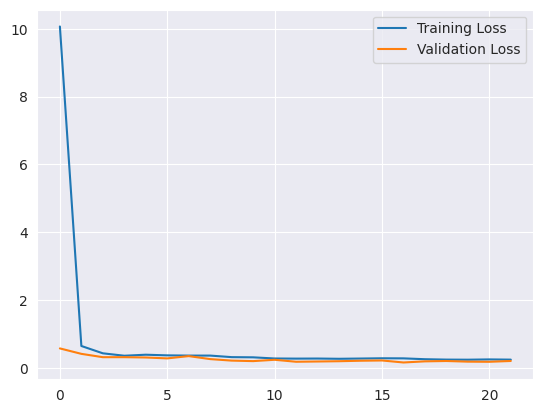

In [10]:
# plot the training and validation loss

plt.plot(history_basic.history['loss'], label='Training Loss')
plt.plot(history_basic.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

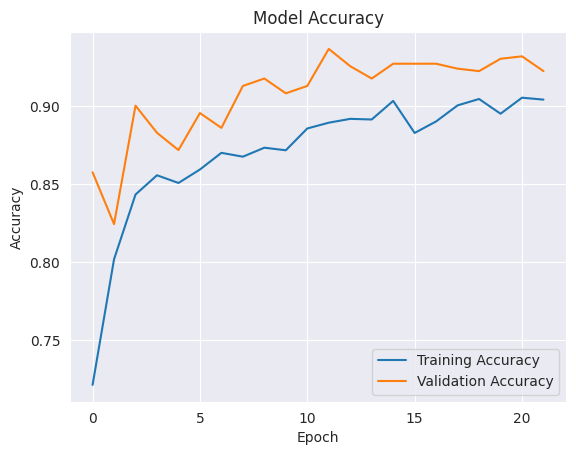

In [12]:
plt.plot(history_basic.history['accuracy'], label='Training Accuracy')
plt.plot(history_basic.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# evaluate the basic model

basic_model.save(f'{save_path}/basic_model.h5', save_format='h5')


if is_colab_env:
    basic_model = load_model(f'{save_path}/basic_model.h5')
else:
    basic_model = load_model('/kaggle/input/cnn-report-v3/basic_model.h5')

basic_model.evaluate(test_ds)

basic_history_df = pd.DataFrame(history_basic.history)
basic_history_df.to_csv(f'{save_path}/basic_model_history.csv')

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.9218 - loss: 0.1756


[0.17014417052268982, 0.9272152185440063]

## VGG16 model with tuning

This will take long times, about 1h.

In [12]:
# use Hyperband to tune the hyperparameters


tuner = GridSearch(
    build_model_vgg16,
    objective='val_accuracy',  # the objective is to maximize the validation accuracy
    max_trials=6,  # 2 * 3 = 6 
    directory='gridsearch_dir',
    project_name='vgg16_tuning'
)


# set EarlyStopping to prevent overfitting


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


# search the best hyperparameters
tuner.search(train_ds, epochs=30, validation_data=test_ds, callbacks=[early_stop])


# get the best model
best_model = tuner.get_best_models(num_models=1)[0]


# print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print("Best learning rate:", best_hyperparameters.get('learning_rate'))
print("Best units in dense layer:", best_hyperparameters.get('units'))

Trial 6 Complete [00h 11m 42s]
val_accuracy: 0.9588607549667358

Best val_accuracy So Far: 0.9651898741722107
Total elapsed time: 01h 06m 31s
Best learning rate: 0.0001
Best units in dense layer: 256


In [13]:
# train the best model


# best_model.summary()

history_best = best_model.fit(train_ds,
                                epochs=30,
                                validation_data=test_ds,
                                callbacks=[early_stop])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 25s 292ms/step - accuracy: 0.9444 - loss: 0.1587 - val_accuracy: 0.9525 - val_loss: 0.1591
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 284ms/step - accuracy: 0.9428 - loss: 0.1732 - val_accuracy: 0.9478 - val_loss: 0.1445
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 297ms/step - accuracy: 0.9395 - loss: 0.1731 - val_accuracy: 0.9604 - val_loss: 0.1169
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step - accuracy: 0.9546 - loss: 0.1351 - val_accuracy: 0.9620 - val_loss: 0.1144
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 293ms/step - accuracy: 0.9599 - loss: 0.1173 - val_accuracy: 0.9636 - val_loss: 0.1190
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 298ms/step - accuracy: 0.9641 - loss: 0.1006 - val_accuracy: 0.9494 - val_loss: 0.1538
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 23s 302ms/step - accuracy: 0.9619 - loss: 0.1143 - val_accuracy: 0.9668 - val_loss: 0.0865
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step - accuracy: 0.9640 - loss: 0.0948 - val_accu

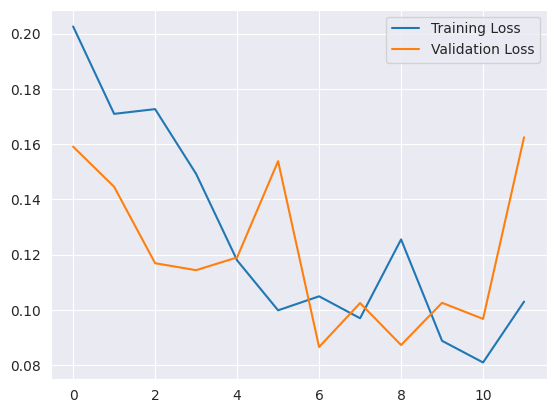

In [14]:
# plot the training and validation loss


plt.plot(history_best.history['loss'], label='Training Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

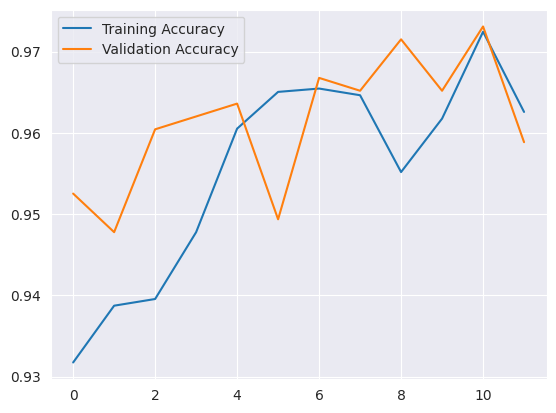

In [14]:
plt.plot(history_best.history['accuracy'], label='Training Accuracy')
plt.plot(history_best.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [15]:
# evaluate the best model

best_model.save(f'{save_path}/best_a_model.h5', save_format='h5')

if is_colab_env:
    best_model = load_model(f'{save_path}/best_a_model.h5')
else:
    best_model = load_model('/kaggle/input/cnn-report-v3/best_a_model.h5')


best_model.evaluate(test_ds)

best_history_df = pd.DataFrame(history_best.history)
best_history_df.to_csv(f'{save_path}/best_model_history.csv')

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - accuracy: 0.9710 - loss: 0.0762


[0.09041236340999603, 0.9620253443717957]

In [17]:
y_pred = []
y_pred_proba = []
y_true = []


for images, labels in test_ds:
    predictions = best_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_pred_proba.extend(predictions)
    y_true.extend(labels.numpy())


y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)
y_true = np.array(y_true)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


In [18]:
class_names = full_dataset.class_names

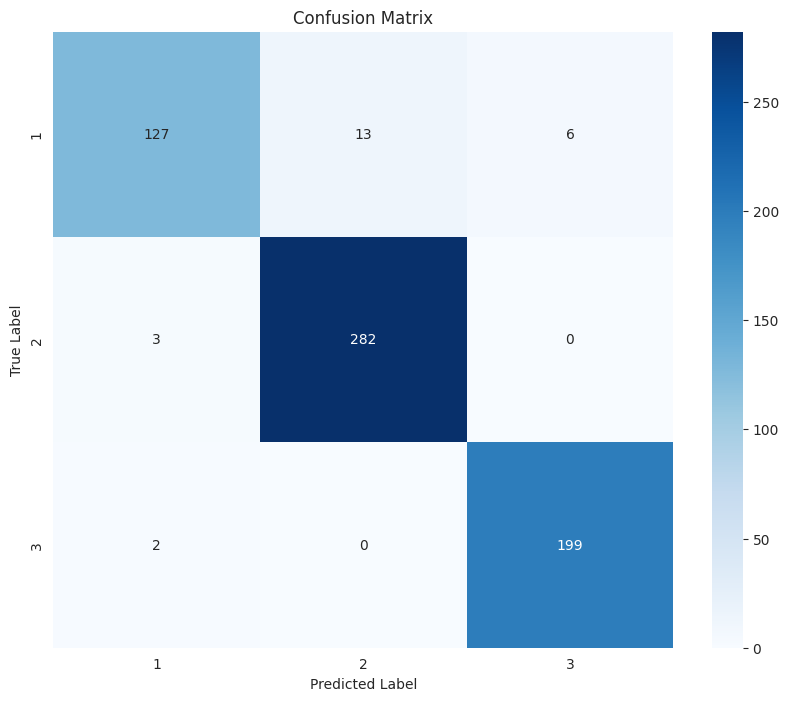


Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.87      0.91       146
           2       0.96      0.99      0.97       285
           3       0.97      0.99      0.98       201

    accuracy                           0.96       632
   macro avg       0.96      0.95      0.96       632
weighted avg       0.96      0.96      0.96       632



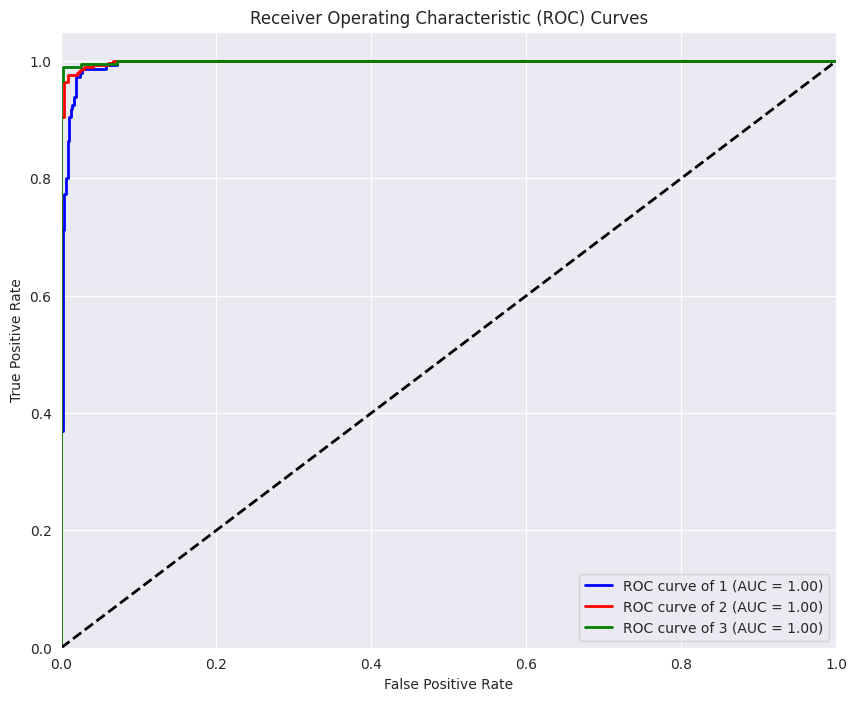

In [19]:
# 1. confusion matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)


plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# 2. classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


# 3. ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC for each class
for i in range(classes_count):
    y_true_binary = (y_true == i).astype(int)
    fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green'])


for i, color in zip(range(classes_count), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})')



plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [20]:
# AUC scores
print("\nAUC scores for each class:")
for i in range(classes_count):
    print(f"{class_names[i]}: {roc_auc[i]:.4f}")


AUC scores for each class:
1: 0.9956
2: 0.9988
3: 0.9995


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


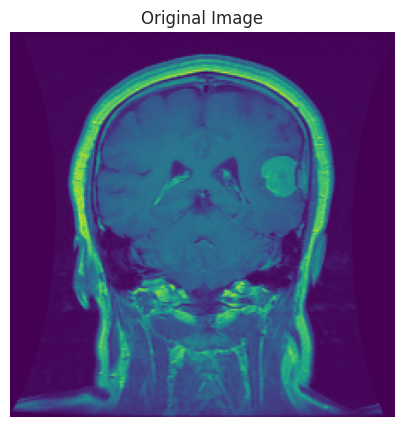

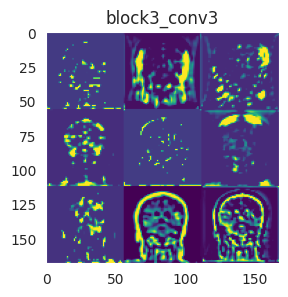

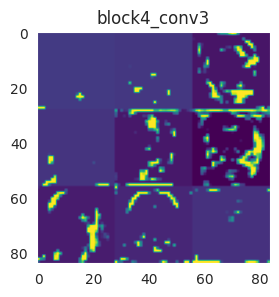

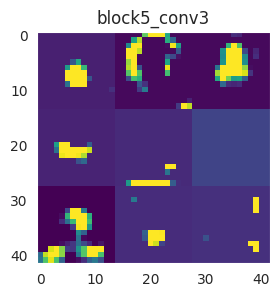

In [36]:
base_model2 = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

layer_names = ['block3_conv3', 'block4_conv3', 'block5_conv3']
outputs = [base_model2.get_layer(name).output for name in layer_names]
feature_model = models.Model(inputs=base_model2.input, outputs=outputs)

sample_image, _ = next(iter(test_ds))
sample_image = sample_image[0:1]

feature_maps = feature_model.predict(sample_image)

# original image
plt.figure(figsize=(5, 5))
plt.imshow(tf.cast(sample_image[0], tf.uint8).numpy())
plt.title("Original Image")
plt.axis("off")
plt.show()

# feature map
for layer_name, feature_map in zip(layer_names, feature_maps):
    num_filters = min(9, feature_map.shape[-1]) 
    size = feature_map.shape[1]
    display_grid = np.zeros((size * 3, size * 3)) 

    for row in range(3):
        for col in range(3):
            channel_index = row * 3 + col
            if channel_index < num_filters:
                x = feature_map[0, :, :, channel_index]
                x -= x.mean()
                x /= x.std() + 1e-5
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                display_grid[row * size: (row + 1) * size, col * size: (col + 1) * size] = x

    scale = 1.0 / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()